<img align="center" src="http://imgur.com/xa4H14d.png" title="To Boldy go!" >

#### Jonathan D. Jarvis, Ph.D.
-----
>*"There is a way out of every box, a solution to every puzzle; it's just a matter of finding it." - Capt. Jean-Luc Picard*

-----
<img align="right" src="http://imgur.com/VeJnaJx.png" title="Primary ST:TNG characters sit for a photoshoot at a local K-mart" width="450">

The inspiration for this notebook came from reading Mollie Pettit's (of Datascope Analytics) clever open-letter to Wesley Crusher, titled [Wesley Crushes Ratings](https://datascopeanalytics.com/blog/wesley-crushes-ratings/).  The burning topic that Mollie addresses is whether we can quantify Wesley's effect on [IMDB ratings](http://www.imdb.com/title/tt0092455/epdate) as a function of the number of lines.  The general upshot is that the more Wesely opens his mouth, the worse an episode's ratings are.  Now, perhaps Wes's skill set is just well aligned with the sort of problems the crew encounters in terrible episodes.  Out of an abundance of fairness to Wesley, who I prejudicially agree is awful, we're going to look at what comes out of his mouth, rather than just how often it opens.

The first stop for any serious Star-Trek fan in need of a fun natural-language processing (NLP) project is http://www.chakoteya.net/StarTrek/index.html.  Chrissie's Transcripts site is well-organized with a minimalist format.  By using *requests*, *BeautifulSoup* and some regular expressions, we can make short work of parsing, cleaning and storing (nearly) every line of dialogue in the Star-Trek universe.  In this notebook, we'll only be using dialogue from *Star Trek: The Next Generation* (ST:TNG), which is my personal favorite, but the same methods and code can be used for the other series as well (TOS, DS9, Voyager, Enterprise).  Once we have parsed and cleaned the dialogue, which is labelled by speaker, we'll use it as a corpus to fit a few common NLP models for capturing semantic relationships.  In particular we'll use *gensim* and its implementations of Latent Semantic Indexing/Latent Semantic Analysis (LSI/LSA: henceforth LSA) and Latent Dirichlet Allocation (LDA).  We'll also get our text ready for processing using the Natural Language Toolkit, *nltk*.

We are interested in examining how linguistically similar the characters are with one another.  In particular, does Wesley have some singular quality that separates him from the other main characters in this semantic hyperspace?  For our first stab at this we'll do the following:

    1) Build a corpus that combines every line of dialogue in ST:TNG
    2) Use that corpus to train an NLP model that captures semantics while reducing dimensionality
    3) Describe a character in this reduced vector space by combining the vectors that represent their lines of dialogue
    4) Compute an appropriate similarity metric between every pair of characters

All things being equal, we might expect similar characters with similar roles to be proximate in this hyperspace; e.g. Worf and Tasha Yar were both Chief of Security on the Enterprise, had fiery dispositions and said things like "Photon torpedoes armed and ready to fire, Captain."  Dr. Crusher and Dr. Pulaski might end up being similar as well, and if we were analyzing ST:TOS we might see the red shirts clustering around some representation of "arghhh" or "gurgle."

Engage!

-----
## Imports

In [2]:
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from collections import Counter, defaultdict
from gensim import corpora, models, similarities, parsing, matutils
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet,stopwords
from scipy.spatial.distance import pdist,squareform

import re
import csv
import requests
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

warnings.filterwarnings('ignore')

-----
## Functions

In [60]:
def print_lsa(lines_char, line_weights, spk, model, ncomp=6, ntop=5, nterms=300, weight=True):
    #convenient function for printing out the top topics and weights for each character's single vector representation
    
    for i,s in enumerate(spk):
        sumvec = sum_vecs(lines_char[i], line_weights[i])
        print('\ncharacter:' + s)
        for x in sumvec[0][0:ntop]:
            print(x[1],' : ',model.print_topics(nterms,ncomp)[x[0]])            

            
def print_lda(testlines, testvecs_lda, model, ncomp=5, nterms=300):
    #convenient function for printing out the lda topics and weights for test phrases

    for idx,x in enumerate(testvecs_lda):
        print('\n' + 'testline #'+str(idx+1) + ' : ' + str(testlines[idx]) + '\n')
        for v in x:
            print(str(v[1]) + ' : ' + model.print_topics(nterms,ncomp)[v[0]][1])            
            
            
def sum_vecs(vecs, line_weights, weight=True):
    #creates a single vector representing a given character; vecs are the line vecs for a single character, line_weights contains
    #the number of corpus words for a given line and weight controls whether the weighting is applied
    
    dt = np.dtype('int,float32')
    lw = np.asarray(line_weights)
    x = np.array(vecs,dtype=dt)['f1']
    vec_sum = np.sum(x*(lw[:,None] if weight else 1),axis=0)
    vec_sum_norm = vec_sum/np.linalg.norm(vec_sum)
    vec_list = sorted(enumerate(vec_sum_norm), key=lambda item: -item[1])

    return vec_list,vec_sum_norm            
            
    
def wn_pos(tb_tag):
    #implementation from: http://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    
    if tb_tag.startswith('J'):
        return wordnet.ADJ
    elif tb_tag.startswith('V'):
        return wordnet.VERB
    elif tb_tag.startswith('N'):
        return wordnet.NOUN
    elif tb_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

-----
## Scraping Episode Links

To begin, we use *requests* to grab the raw source.  The image below shows a section of the html on the main ST:TNG-episodes page.  Knowing its structure, we can use *BeautifulSoup* to scrape all of the episode links.  The method we use below is a bit more verbose than what's required to simply grab every link from the page; however, by parsing table rows (`<tr>`) one at a time we can easily grab other data, such as "Airdate" and "Episode Name."  We do pick up a spurious link for the main page, but this is inconsequential as no lines are detected when it is parsed; even so, we'll delete it manually from the list.

<img align="center" src="http://imgur.com/FZOeglt.png" title="Episodes page for ST:TNG">

In [4]:
#scrape all episode links from the ST:TNG episode page; helpful link here:
#https://journalistsresource.org/tip-sheets/research/python-scrape-website-data-criminal-justice

url_to_scrape = 'http://www.chakoteya.net/NextGen/episodes.htm'
r = requests.get(url_to_scrape)
soup = BeautifulSoup(r.text)
episode_links = []
new_url = url_to_scrape[:(url_to_scrape.rfind("/")+1)]

for table_row in soup.select('tr'):  #iterate through all table row (tr) tags in the document
    
    table_cells = table_row.findAll('td')  #find every table cell (td) tag
    
    if len(table_cells) > 0:
        try:
            relative_link_to_episode_details = table_cells[0].find('a')['href']   #scan for an href attribute
            absolute_link_to_episode_details = new_url + relative_link_to_episode_details  #create an absolute link to page
            episode_links.append(absolute_link_to_episode_details)  #append to list of episode links
        except:
            pass

In [5]:
display(episode_links[-4:])

['http://www.chakoteya.net/NextGen/275.htm',
 'http://www.chakoteya.net/NextGen/276.htm',
 'http://www.chakoteya.net/NextGen/277.htm',
 'http://www.chakoteya.net/NextGen/../StarTrek/index.html']

-----
## Scraping Lines and Speakers
<img align="right" src="http://imgur.com/TUqNelh.png" title="Example of the script for an episode link" width=600>
The image to the right shows a transcript sample from an episode link.  The overwhelming majority of the lines are followed by a break tag (`<br>`) and have a format given by 'SPEAKER: line'.  There are also variety of lines that include contextual information, either with the speaker's name or in the line itself; e.g. 'DATA [OC]: .....' or 'TASHA: (to Riker) This way, sir.'  These are relatively few in number, but I've added some additional regular expressions to accomodate them.  The only lines that I haven't bothered with are the few that come after a paragraph tag.

We use *BeautifulSoup* to find every `<br>` and then use the `nextSibling` method to pick out a possible line of dialogue.  To determine if that text is indeed dialogue, we scan for the appropriate patterns and append filtered versions of the match object to the speaker and line lists.  In this case, we've removed any square-bracketed text from the speaker name, and we've stripped away parenthetical text, punctuation, possessive endings, new-line characters and spurious whitespaces.        

In [6]:
line_list = []
speaker_list = []

for link in episode_links[:-1]:
    time.sleep(0.1)
    print('\r',link, end='')
    rl = requests.get(link)
    lsoup = BeautifulSoup(rl.text)
    for br in lsoup.select('br'):
        try:
            line = br.nextSibling
            matchtext = re.search(r'([A-Z]+|.+\]):\s(.+)', line, re.S)
            speaker_name = re.search(r'[A-Z]+',matchtext.group(1)).group()  #scanning speaker name from group(1)
            speaker_list.append(speaker_name)
            
            # \s+$ = spurious whitespace at end, \([^\)]+\) = all parentheticals,  [^\w\s]s* = punctuation and possessive
            pat_list = [r'\s+$', r'\([^\)]+\)', r'[^\w\s]s*']  #list of patterns to delete
            patterns = '|'.join(pat_list)
            line_scrub = re.sub(patterns, '', matchtext.group(2).replace('\n',' '))
            line_list.append(line_scrub)
        except:
            pass

 http://www.chakoteya.net/NextGen/277.htm

In [7]:
#checking shape of the lists and the number of unique entries
print('total lines of dialogue: ' + str(len(speaker_list)), '\nnumber of unique speakers: ' + str(len(list(set(speaker_list)))))
print('total lines: ' + str(len(line_list)), '\nnumber of unique lines: ' + str(len(list(set(line_list)))))

total lines of dialogue: 58523 
number of unique speakers: 736
total lines: 58523 
number of unique lines: 51572


In [8]:
#[print(speaker_list[idx], ':', line_list[idx]) for idx,x in enumerate(speaker_list[0:10])]
print('Example dialogue with corresponding speakers:\n')
pprint(line_list[-5:])
print('\n',speaker_list[-5:])

Example dialogue with corresponding speakers:

['Of course Have a seat',
 'Would you care to deal sir',
 'Oh er thank you Mister Data Actually I used to be quite a card player in my '
 'youth you know I should have done this a long time ago',
 'You were always welcome',
 'So Five card stud nothing wild and the sky the limit']

 ['RIKER', 'DATA', 'PICARD', 'TROI', 'PICARD']


In [9]:
#checking the most common lines and the most frequent speakers
#set([x for x in line_list if line_list.count(x)>1])
print('Most common lines: ',Counter(line_list).most_common(5))
print('Most frequent speakers: ',Counter(speaker_list).most_common(5))

Most common lines:  [('Aye sir', 566), ('Yes', 274), ('Yes sir', 242), ('No', 174), ('What', 114)]
Most frequent speakers:  [('PICARD', 11436), ('RIKER', 6752), ('DATA', 5747), ('LAFORGE', 4059), ('WORF', 3513)]


In [10]:
#Export speaker list to file for safe keeping
with open('speaker_list.txt','w') as f:
    for line in speaker_list:
        f.write('{}\n'.format(line))

-----
### Quick Visualizations of Speakers and Lines

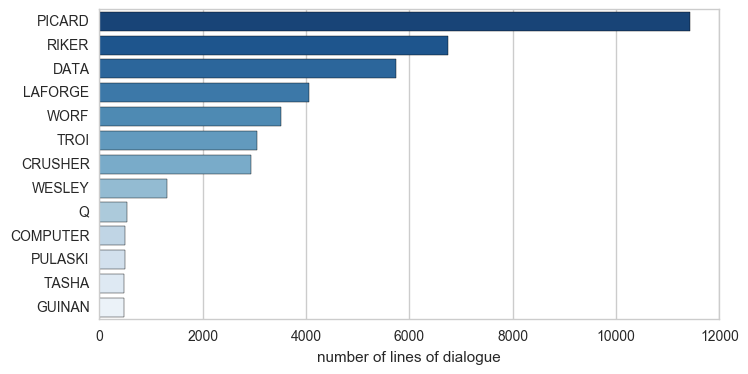

In [11]:
#Plotting the top speakers by num. of lines
Nplot = 13
Nmain = 30
top_speakers = [x[0] for x in Counter(speaker_list).most_common(Nmain)]
top_speakers_num = [float(x[1]) for x in Counter(speaker_list).most_common(Nmain)]

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=top_speakers_num[:Nplot], y=top_speakers[:Nplot], palette='Blues_r')
ax.set(ylabel="", xlabel="number of lines of dialogue")
plt.show()

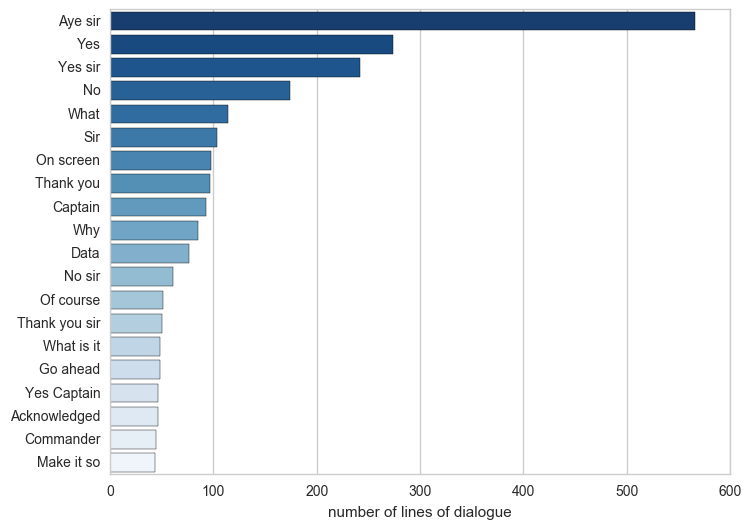

In [12]:
#Plotting the super-banal top-20 lines (only considers exact matches; no semantics!)
top_lines = [x[0] for x in Counter(line_list).most_common(20)]
top_lines_num = [float(x[1]) for x in Counter(line_list).most_common(20)]

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=top_lines_num, y=top_lines, palette='Blues_r')
ax.set(ylabel="", xlabel="number of lines of dialogue")
#ax.set_xscale('log')
plt.show()

-----
# Getting Ready for NLP
It's clear that there is a great deal of application-specific 'art' involved with NLP.  Generally, our objective is to produce a compact representation of our text that captures meaning and can be used to answer specific questions of interest.  Accordingly, we want to use preprocessing techniques that support this objective.  There are a variety of techniques for making our representation more compact, including stop words, pruning, stemming and lemmatization.  We'll also look at term frequency-inverse document frequency (tf-idf), a scaling method that adjusts the importance of words based on the frequency with which they occur in our text.

-----
## Stop Words
Stop words are words that are sometimes eliminated from an NLP corpus due to their pervasiveness and corresponding lack of discriminative power.  The selection of stop words is highly specific to the particular application and domain.  In this notebook, we'll use the English stop-words list from *nltk* as well as some domain specific words and names, which are stored in the custom set `customstop`.  Note that the use of stop words is an important preprocessing step before running LDA in particular.  From here on, we'll want to have our lines in all lowercase.

In [13]:
#splitting every line into individual words; 
line_list_split = [x.lower().split() for x in line_list]
[print(line_list_split[-3+i]) for i in range(3)];

['oh', 'er', 'thank', 'you', 'mister', 'data', 'actually', 'i', 'used', 'to', 'be', 'quite', 'a', 'card', 'player', 'in', 'my', 'youth', 'you', 'know', 'i', 'should', 'have', 'done', 'this', 'a', 'long', 'time', 'ago']
['you', 'were', 'always', 'welcome']
['so', 'five', 'card', 'stud', 'nothing', 'wild', 'and', 'the', 'sky', 'the', 'limit']


In [14]:
customstop = set(('captain lieutenant commander ensign sir im u go doctor mr mister jeanluc la forge deanna talk ask' + 
                 ' jean luc beverly geordi will william obrien o keiko katherine robin lefler miles sonya alyssa').split())
namesstop = set([x.lower() for x in speaker_list])
stoplist = set(stopwords.words('english'))| customstop | namesstop
line_list_stop = [[x for x in splitline if x not in stoplist] for splitline in line_list_split]

----
## Pruning
We can also consider eliminating words that have a very low occurrence rate, e.g. one or two occurrence in the entire corpus.  A sample size of one is not terribly informative when trying to capture co-occurrence statistics.  It's possible that some of these are mispellings of other words or the proper name of a red-shirt ready to meet their doom; e.g. "Has anyone seen Ensign McPuddle?"  We examine the list of these words from the first 100 lines to convince ourselves that they won't be missed.  Note that *gensim* has a nice `utils` module that includes a wide variety of these sorts of simple manipulations; in this case the `utils.prune_vocab()` method would achieve the same result.

In [15]:
#analyzing line list for term-frequency across the entire dataset.  Gensim has a module for doing
#term-frequency_inverse document frequency (tf-idf), which we use below
freq_min = 2
freq_max = 1500

term_freq = defaultdict(int)

for line in line_list_stop:
    for word in line:
        term_freq[word] += 1

#term_list_sorted = [(k, term_freq[k]) for k in sorted(term_freq, key=term_freq.get, reverse=True)]

line_list_drop = [[word for word in line if (term_freq[word]<=freq_min) | (term_freq[word]>=freq_max)] 
                  for line in line_list_stop] #lines occurring too frequently or infrequently

line_list_min = [[word for word in line if (term_freq[word]>freq_min) & (term_freq[word]<freq_max)]
                  for line in line_list_stop] #lines occurring more than once

term_freq_min = defaultdict(int)

for line in line_list_min:
    for word in line:
        term_freq_min[word] += 1

term_list_sorted = [(k, term_freq_min[k]) for k in sorted(term_freq_min, key=term_freq_min.get, reverse=True)]

        
print(len(line_list_drop),line_list_drop[0:100])

58523 [[], [], [], ['time'], [], ['encyclopedia', 'like'], [], [], ['stealthily', 'slink', 'slither'], ['yes'], ['glide', 'skulk', 'pussyfoot', 'gumshoe'], [], [], [], ['could'], [], [], [], [], ['thy', 'infiltrated'], ['would', 'identifying'], ['mayst'], ['ship', 'mayst', 'whence', 'camest'], ['medics'], [], ['would'], ['dost', 'wouldst', 'shalt'], ['patriotism', 'commies'], ['us'], ['youre'], ['like'], ['time', 'divide', 'quarrels', 'godimages'], ['like'], [], [], [], [], [], ['right'], ['yes'], ['struggles'], ['selfrighteous', 'dont'], ['well'], ['us'], ['youre', 'veritable', 'well'], [], [], [], [], ['intercom', 'well', 'see'], [], ['detaching'], [], [], [], ['printout', 'youre', 'know', 'well', 'well'], [], [], [], [], [], [], [], ['us'], ['guesses'], ['like'], [], [], [], ['us'], [], [], [], ['magnifying'], [], [], ['us'], [], [], [], [], [], [], ['printout'], [], [], [], ['ship', 'startime'], [], [], [], [], [], [], [], [], ['detonated'], [], ['decelerating'], ['well']]


Let's do a quick histogram of our term frequencies to see how they are distributed.

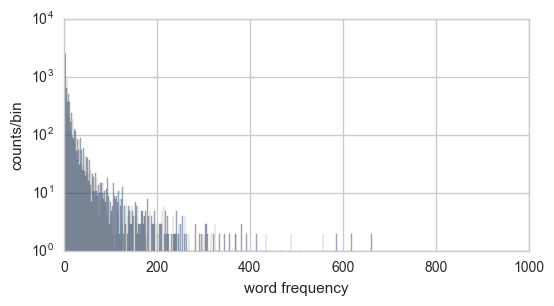

In [16]:
ltest = list(term_freq_min.items())
wordfreq = [x[1] for x in ltest]
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 3))
sns.distplot(wordfreq, 1000, kde=False)
ax.set(ylabel="counts/bin", xlabel="word frequency")
ax.set_yscale('log')
ax.set_xlim([0,1000])

plt.show()

In [17]:
#Top 10 most frequent terms:
print(term_list_sorted[0:10])

[('get', 1445), ('going', 1389), ('want', 1365), ('way', 1205), ('two', 1201), ('take', 1165), ('something', 1112), ('enterprise', 1094), ('let', 1060), ('ive', 1045)]


In [18]:
#Export filtered line_list to file
with open('line_list.csv','w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(line_list_min)

-----
## Lemmatization and stemming:
When building semantic representations of documents, does it make sense to have happy, happier, happiness and happiest be distinct entities, effectively assuming no a priori connection between them?  If we are most interested in say determining topics or sentiment, then perhaps not.  One approach might be to reduce the representation of these words to their common stem 'happ.'  Notice that we've compressed out information about the part of speech as well as the degree of our happy state, e.g. 'happier' vs. 'happiest.'  This process of reducing similar words to their common stem is known as "stemming," and there are a variety of stemming methodologies, e.g. Porter, Paice, Lovins.  

Lemmatization is a more sophisticated form of compression that incorporates part of speech information.  For example, 'swimmers' and 'swiming' might become 'swimer (noun)' and 'swim (verb),' respectively.  In contrast, stemming might assign both words to 'swim.'  We'll opt for lemmatization and use the `WordNetLemmatizer` module from *nltk*, but first we'll need to infer the part of speech (PoS) for each term using *nltk*'s PoS tagger, `pos_tag`.  

Note:  Perhaps we are interested in preserving speaking "style" rather than just topics; in this case we might pass on filtering with these methods.  We'll keep a non-lemmatized, non-stemmed version of our line list around for comparison (called `line_list_stop`).

In [19]:
lemma = WordNetLemmatizer()
#tokens = [word_tokenize(x) for x in testlines]
tokens_pos = [pos_tag(x) for x in line_list_min]
line_list_lemm = [[lemma.lemmatize(x,wn_pos(tokens_pos[j][i][1])) for i,x in enumerate(line)] 
                  for j,line in enumerate(line_list_min)]

In [20]:
lnum = 4740
print(line_list_lemm[lnum],'\n',line_list_min[lnum])

['obviously', 'still', 'aboard', 'another', 'starfleet', 'vessel', 'must', 'send', 'intercept', 'enterprise', 'bynaus', 'might', 'take', 'home', 'planet'] 
 ['obviously', 'still', 'aboard', 'another', 'starfleet', 'vessel', 'must', 'sent', 'intercept', 'enterprise', 'bynaus', 'might', 'taking', 'home', 'planet']


-----
## Word Mappings
Here we'll use the `corpora.Dictionary` module of *gensim* to generate a mapping between unique words and ID numbers.  With these mappings we can create a bag-of-words (BoW) representation of our corpus, or any other phrase for that matter.  BoW encoding is accomplished using the `doc2bow` method.

In [21]:
#Use gensim to create a word-ID dictionary (change the Dictionary argument to line_list_lemm for lemmatized version)
line_dictionary = corpora.Dictionary(line_list_lemm)
line_dictionary.save('/STTNG_dict.dict')
print(line_dictionary,'\n', random.sample(line_dictionary.token2id.items(),5)) #five random examples; could also use utils.sample_dict

Dictionary(7293 unique tokens: ['appetite', 'happen', 'drill', 'cargo', 'lockouts']...) 
 [('primitive', 3483), ('frozen', 95), ('attempt', 299), ('humiliation', 4960), ('unreasonable', 2976)]


In [22]:
#Use our mappings to create a bag-of-words representation of the corpus
#(change the Dictionary argument to line_list_lemm for lemmatized version)
fullcast_corpus = [line_dictionary.doc2bow(line) for line in line_list_lemm]
corpora.MmCorpus.serialize('/STTNG_corpus.mm',fullcast_corpus) #saving the sparse, full-cast corpus to file
[print(x) for x in fullcast_corpus[0:3]];  #dictionary encoding of the first few lines of dialogue

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
[(6, 1)]
[(0, 1), (2, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


Let's define some test phrases that would be plausibe in ST:TNG and throw in a Mark Twain/Samuel Clemens quote for fun.

In [23]:
testlines = ['charge phasers arm photon torpedoes and prepare to fire', 
             'transporter chief beam the away team directly to sickbay',
            'why shouldnt truth be stranger than fiction fiction after all has to make sense']
testvecs = [line_dictionary.doc2bow(x.lower().split()) for x in testlines]
[print(x) for x in testvecs];

[(220, 1), (302, 1), (305, 1), (417, 1), (874, 1), (927, 1)]
[(593, 1), (797, 1), (799, 1), (823, 1), (1868, 1)]
[(44, 1), (147, 1), (694, 1), (1331, 1), (1549, 1), (2814, 2)]


In [24]:
#an imdb plot summary for the episode "Time Squared"
timesquared = 'deep in space the enterprise comes across a federation shuttle craft that is floating in space and without much power but which does exhibit the life signs of one human aboard they bring the craft aboard only to find that it is one of their own shuttle craft and to their amazement find a duplicate but unconscious captain picard aboard data and geordi laforge manage to restore power and determine that the craft actually comes from 6 hours into the future and the shuttles log reveals that the enterprise will be destroyed as the enterprise enters a dangerous vortex and the events in the recovered shuttles log seem to be coming true picard and the crew must find a way to break the timewarp cycle they seem to be in'
tsvec = line_dictionary.doc2bow(timesquared.lower().split())
print(tsvec)

[(15, 1), (19, 3), (26, 1), (30, 1), (67, 2), (85, 1), (106, 1), (111, 1), (120, 1), (173, 2), (179, 1), (195, 1), (224, 3), (322, 2), (340, 1), (347, 1), (419, 1), (505, 2), (560, 3), (1005, 2), (1044, 1), (1074, 1), (1122, 1), (1236, 1), (1323, 1), (1668, 1), (1906, 1), (1938, 1), (1970, 1), (2346, 1), (2865, 1), (2873, 1), (3457, 1), (3514, 2), (3693, 1), (4024, 1), (4138, 1), (4253, 4), (5677, 1), (6359, 1), (6389, 1), (6639, 1)]


-----
## Fitting Some NLP Models to the Corpus

Next we'll fit our corpus with the tf-idf model in *gensim*.  Once the model has been fit, we can use it to transform any string of text.


## tf-idf
Generally, we'd like our semantic representations to emphasize words that occur frequently in individual documents but infrequently across the entire set.  Term frequency-inverse document frequency (tf-idf) is a scaling method commonly used for this purpose.  Tf-idf involves multiplying each term in a document by two factors, $\mathrm{tf}$ and $\mathrm{idf}$,

$$\mathrm{tf}(t,d)=N_{t}^{(d)}$$

$$\mathrm{idf}(t)=log\frac{N_{D}}{N_{t\, \in \, D}},$$

where $t$ is a given term, $N_{t}^{(d)}$ is the number of occurrences in document $d$, $N_{D}$ is the total number of documents, and $N_{t\, \in \, D}$ is the number of documents in which term $t$ occurs.  We see that in the limiting case where a word is present in every line of dialogue, the $\mathrm{idf}$ term will evaluate to zero and effectively remove the word from the corpus.  The effect of idf is similar to the use of stop words; however it is continuous in nature and does not requre any subjective user input (e.g. a stop-word list).  For comparison, we'll make a version of our corpus that uses tf-idf without any stop words.

In [25]:
tfidf_corpus = models.TfidfModel(fullcast_corpus)
fullcast_tfidf = tfidf_corpus[fullcast_corpus]
testvecs_tfidf = tfidf_corpus[testvecs]
tsvec_tfidf = tfidf_corpus[tsvec]
#[print(vec) for vec in fullcast_tfidf[0:2]];
print(testvecs[0],'\n',tfidf_corpus[testvecs[0]]);

[(220, 1), (302, 1), (305, 1), (417, 1), (874, 1), (927, 1)] 
 [(220, 0.36814897039157474), (302, 0.451717711973294), (305, 0.4131025994217461), (417, 0.44619453297731304), (874, 0.4014671431679514), (927, 0.35985866439194325)]


-----
## Latent Semantic Analysis

In tf-idf we've tried to increase the emphasis placed on words that can help us discriminate between different lines; however, our corpus still consists of very sparse vectors and has its original dimensionality.  In other machine-learning problems, we might look to reduce the dimensionality of our data using principal component analysis (PCA), sequential backward selection (SBS) or a random forest (by selecting features that tend to maximize information gain in the constituent trees).  Just as PCA uses singular value decomposition (SVD) to recast a dataset according to the eigenvectors of its covariance matrix, LSA applies SVD to the sparse, term-document representation of our corpus to compute a dense basis of vectors.  This isn't desirable for every application, but it is an effective means of reducing dimensionality and noise when we are interested in topics and semantics.  Note that LSA can be applied to any sparse representation of our data; it does not require a BoW with integer values for each term.  We'll do our LSA on top of tf-idf to prevent common terms from polluting our eigenvectors and giving the impression of similarity where there is none.

We'll start with ~300 topics for our reduced representation, but this is a hyperparameter that would be adjusted via cross-validation if we were interested in doing classification, for example.


**Note**: The parameters for all of the preprocessing techniques we used would typically determined through cross validation for our specific task (though in our case, there isn't really a supervised task to speak of).  One way to try that here would have been to randomly split the lines for each character into training and cv/test sets and then traing a classifier (that operates on our LSA-transformed lines) to predict the speaker on each test-set line.  We could then make a series of learning curves to help nail down good values for stop words, frequency filtering and whether we should lemmatize/stemm or not.  For values where the classifer can achieve low generalization error, it suggests(perhaps!) that the preprocessing+LSA has featurized the data in a semantically meaningful way.

In [26]:
#Fitting an LSA/LSI model to the tf-idf transformed corpus and printing vector 47!
lsa = models.LsiModel(fullcast_tfidf, id2word=line_dictionary, num_topics=300)
cast_lsa = lsa[fullcast_tfidf]
lsa.print_topics(300,10)[47]

(47,
 '0.524*"stop" + 0.367*"anything" + 0.360*"long" + 0.289*"really" + 0.192*"shield" + -0.185*"never" + -0.185*"thing" + -0.172*"feel" + 0.146*"wrong" + -0.143*"ive"')

### Similarity
Now that we have a dense vector representation of our corpus, we can compute the cosine-similarity matrix and make efficient queries against it.  In the code below, we compute the similarity of our lsa-transformed testvecs (`testvecs_tfidf`) against the corpus and list the 10 most similar lines of dialogue.

In [27]:
lsa_index = similarities.MatrixSimilarity(cast_lsa)
lsa_index.save('/STTNG_lsa_sim.index')

In [28]:
sims_testvecs = [lsa_index[x] for x in lsa[testvecs_tfidf]]
sims_sorted = [sorted(enumerate(x), key=lambda item: -item[1]) for x in sims_testvecs]
print(sims_sorted[0][0:10])

[(17555, 0.96858513), (12586, 0.87583613), (11589, 0.82030284), (17494, 0.77575368), (9292, 0.76073372), (31025, 0.75405949), (6849, 0.74019706), (1276, 0.73978585), (9383, 0.73499805), (32943, 0.73499805)]


In [29]:
# This feels to heavy on the list comp; should probably make a little print function instead!
[print('test phrase #' + str(idx+1) + ': ' + testlines[idx] + '\n\n',[line_list[x[0]] for x in example[0:10]],'\n') 
 for idx,example in enumerate(sims_sorted)];

test phrase #1: charge phasers arm photon torpedoes and prepare to fire

 ['Worf arm phasers and photon torpedoes Prepare to fire', 'They are preparing to fire photon torpedoes', 'Well only need one Stand by on phasers and torpedoes Prepare to fire them simultaneously', 'Lieutenant Worf fire phasers on full with a simultaneous spread of torpedoes', 'Recommend we fire a photon torpedo Captain', 'Lieutenant Barclay to Captain Picard You can fire photon\r torpedoes', 'Phasers and photons firing We missed', 'I have phasers and torpedoes armed but I show insufficient power to fire them', 'Fire torpedoes', 'Fire torpedo'] 

test phrase #2: transporter chief beam the away team directly to sickbay

 ['Can we beam down an away team through one of those holes', 'Transporter Chief beam the away team directly to the Bridge', 'Away team to Enterprise Beam us up Now', 'Transporter room do you have a fix on the away team', 'Beam up the away team immediately', 'Time to come home now Number One Transpo

In [30]:
#Speakers for the lines that are most similar to the Clemens quote
print([speaker_list[x[0]] for x in sims_sorted[2][0:10]])

['LAFORGE', 'TACTICIAN', 'CRUSHER', 'WESLEY', 'NILREM', 'DATA', 'TROI', 'ROGA', 'PICARD', 'TROI']


The STTNG-plausible test phrases look great; unsurprisingly, the corpus is well equipped to arm the photon torpedoes and handle emergency transporter operations.  The closest matches for the Clemens quote are also interesting.  They are devoid of any sci-fi terminology (as is the test phrase) and clearly capture the content, if not its profundity.  

**nb**:  Samuel Clemens was featured prominently in a two-part ST:TNG episode 'Time's Arrow,' but sadly, none of these lines are his :)

-----

## Computing the Character-Similarity Matrix

Next we'll take a (very) rough stab at determining the similarity between the major characters.  First, we'll sort the tf-idf/lsa transformed lines according to character.  We'll then sum all of the line vectors for a given character and normalize; this lets us describe the 'average' speech of a given character as a single vector, $\hat{\mathbf{v}}_{character}$, in our compressed representation.  Finally, we can compute the cosine similarity (e.g. $\hat{\mathbf{v}}_{picard}\cdot\hat{\mathbf{v}}_{worf}$) between the characters to generate a map of the pariwise relationships.  We can take the norm of these parwise-similarity vectors to get scalar values that describe the overall similarity of each character with the rest of the cast.

In [31]:
#This creates a list where each element contains all valid lines from a single "top speaker"
#I've removed a small fraction of the lda-transformed lines that were misshapen, having 0 or 299 rather than 300 elements
#Zeros are lines that were stop-worded out of existence; not certain who the 299s are...could investigate but inconsequential

Ntop = 300
char_list = top_speakers[0:20]
char_dict = {x: i for i, x in enumerate(char_list)}
lines_char = [[(idx,line) for idx,line in enumerate(cast_lsa) if (speaker_list[idx]==name and len(line)==Ntop)] 
              for name in char_list]
idx_lines = [[line[0] for line in x] for x in lines_char]
lines_char = [[line[1] for line in x] for x in lines_char]
num_per_line = [[len(fullcast_corpus[idx]) for idx in x] for x in idx_lines]

In [32]:
#quick check of the weighting values (number of words per line)
num_per_line[0][0:10]

[1, 14, 8, 3, 1, 5, 4, 3, 1, 4]

In [33]:
#Top speakers, in order
print(top_speakers[0:20])

['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF', 'TROI', 'CRUSHER', 'WESLEY', 'Q', 'COMPUTER', 'PULASKI', 'TASHA', 'GUINAN', 'LWAXANA', 'BRIEN', 'RO', 'BARCLAY', 'VASH', 'ALEXANDER', 'EHLEYR']


In [34]:
#sum_vecs should have num_per_line[idx] and weight=True if we want to scale the importance of each line based on its length
#for equal weights, leave num_per_line[idx] in and simply set weight=False
#the sum_vec is normalized either way before it is returned
char_vec_norm = [sum_vecs(x,num_per_line[idx])[1] for idx,x in enumerate(lines_char)]
sim_matrix = -squareform(pdist(char_vec_norm, metric='cosine'))+1

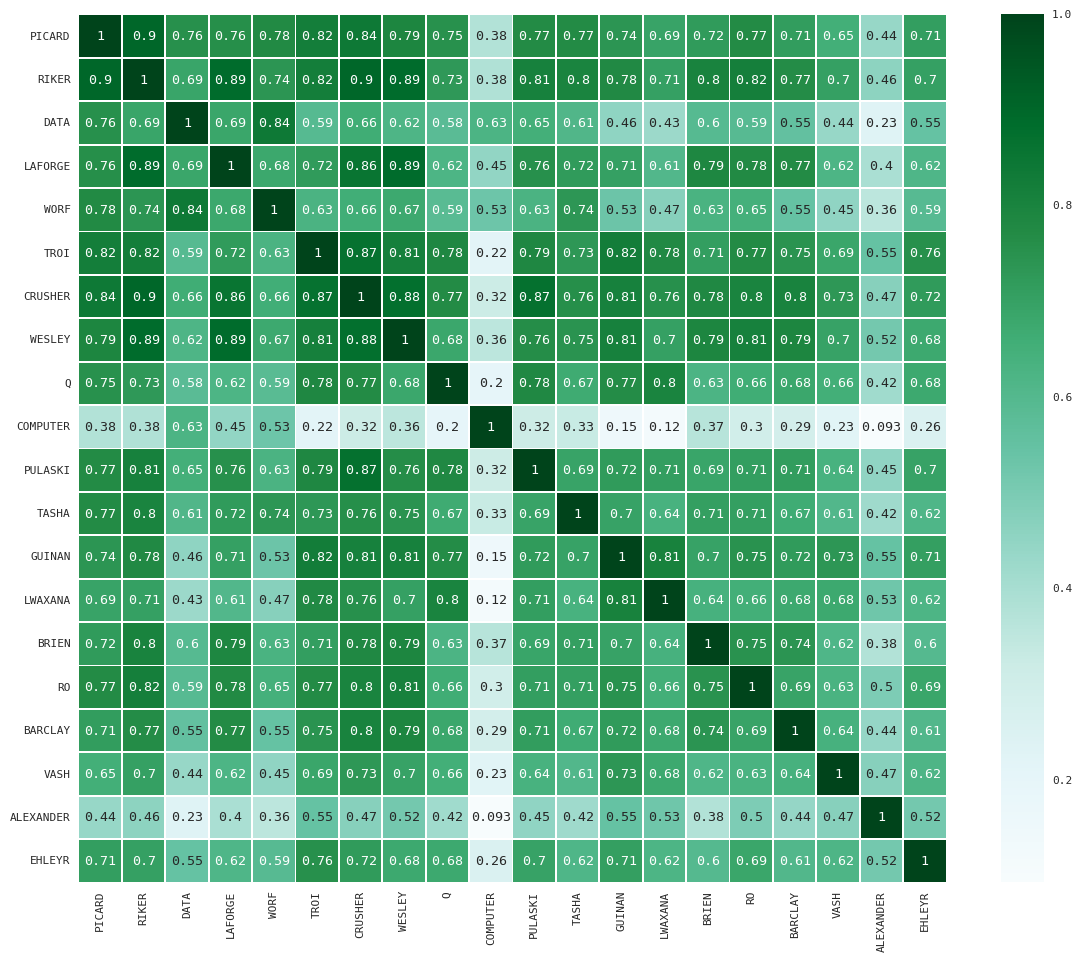

In [35]:
#implementation from: http://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white", context="paper", font="monospace")

mask = np.zeros_like(sim_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#to put a upper-triangular mask on, put mask=mask in the arguments; I've opted for the symmetric representation because
#it's quicker to see a character's entire vector at a glance.

sns.heatmap(sim_matrix, cmap='BuGn', square=True, linewidths=.5, yticklabels=top_speakers[0:20], 
            xticklabels=top_speakers[0:20] , cbar_kws={"shrink": 0.8}, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

In the chart below, we have taken the average similarity for each character across the entire (reduced) cast:

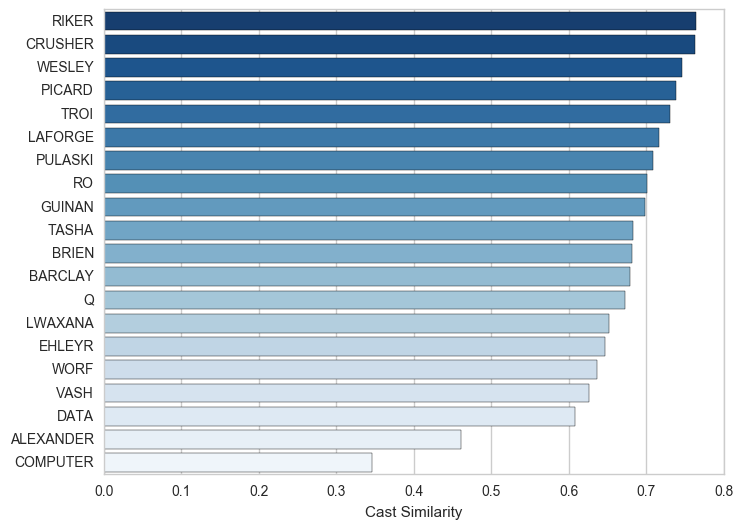

In [36]:
sim_sum = np.mean(sim_matrix,axis=1)
sim_args = sim_sum.argsort()
sim_sort = sim_sum[sim_args[::-1]]
speaker_sort = [top_speakers[x] for x in sim_args[::-1]]

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=sim_sort, y=speaker_sort, palette='Blues_r')
ax.set(ylabel="", xlabel="Cast Similarity")
plt.show()

## What's in a Character?

Interpreting the 'meaning' of these compact NLP representations can be difficult; this is especially true of BoW models, which unlike humans, do not consider the serial nature of language and only weakly capture semantics.  Recently, there have been some impressive successes in the area of word-embeddings (i.e. creating efficient, continuous vector-space representations of words), e.g. [word2vec](https://code.google.com/archive/p/word2vec/), which captures co-ocurrence statistics via a [skip-gram model](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), and extensions to longer strings of text like [paragraph vectors](https://arxiv.org/abs/1405.4053) and [skip-thought vectors](https://arxiv.org/abs/1506.06726).  It would be interesting to extend this analysis with those techniques.  Recognizing the limitations of our results here, we'll make some fun observations:

**1)**  The computer (which is normally the Enterprise's computer, but it probably includes lines from other federation computers as well...), is almost universally dissimilar to humanoid characters.  This could be because it tends to discuss a very wide range of topics in a sterilized manner; e.g. the computer does everything from reciting data held in historical archives, to reporting that Commander Riker is located on holodeck 4, to waxing poetic with La Forge on matters in engineering.  It's also apparent that the computer has similarity coldspots on characters who are generally less technical and have a more emotive nature to their arc and language, e.g. Alexander, Lwaxana, Guinan, Vash, Q and Troi.  To put this on more solid ground we should also look at the co-occurence statistics for the appearance of characters in the same episode; there may be a clumpiness in the data related to being in the same episodes and, as a result, discussing similar topics.
    
**2)**  Poetically, Data is the main character that is most similar to the ship's computer.  Sorry, Mr. Data; the journey to become more human continues (though not really, because you blew up in Nemesis...unless we are counting B4).  It's interesting to note that Data is a close analog to the computer in the sense described above: often asked to recite archival records or make technological/scientific prognostications.  Additionally, he frequently discusses concepts related to human experience and emotion and executes issues orders concerning navigation and tactical operations etc...  He has the least in common with a 3/4 klingon, 1/4 human child, which seems about right.

**3)**  Worf has the least in common with his son, which is appropriate based on the level of relational difficulty he has with Alexander in the series.  Somehow, his highest degree of similarity is with Data.  Perhaps this is a result of the general sterility with which they speak.  Worf's similarity with Tasha is unremarkable.  Tasha's numbers are rather flat across the board, possibly related to her fairly early exit from the series and a reasonably wide sampling of subject matter (technical, tactical, emotional, relational etc..).  We see the same sort of thing with Dr. Pulaski, except by a large margin, her greatest similarity is with Dr. Crusher; check.  
 
**4)**  Interestingly, three of the bottom six characters (by total similarity) are klingon (well, half-blooded or more), two are machines and one is a jet-setting, rogue-achaeologist love interest for mon capitaine.

**5)**  We also note that generally, the hotspots shared by the top speakers (by number of lines) are much hotter; note the clustering of deep green in the upper-left quadrant.

You may have noticed that we discussed many things and none of them were Wesley.  Sadly, there isn't a shocking takeaway from the data, like there is for the synthetic characters, but that's largely what we came for so here is one attempt at an upshot:  

#### They tried to make you too many things.

I understand that we needed a precocious character that could be a proxy for young viewers.  We were all standing in the shadow of the STS and dreaming of exploring the universe.  But, by any reasonable measure, a kid having high similarity with the first officer; the chief of engineering; the chief medical officer (related or otherwise); ship's counselor; the sagacious bartender; a maverick, bajoran-resistance fighter; and to top it off, making you some sort of space-time guru... it's too much.  If you had started the show in your mid 20's, then perhaps.  It also doesn't help that you have high similarity with Alexander; that part makes sense.

Well done, Wes, now get off my ship.

<img align="center" src="http://imgur.com/AKa4IpR.png" title="I hope we reintegrate your matter stream properly" width="600">

-----
### For completeness...

Below are the 10 most important vectors (top-5 components) for describing each major character; it's verbose but worth seeing.  You'll notice a reasonable amount of what could be noise; e.g. short 'function' words (verses 'content' words) that didn't get taken out by our filters.  You could go on refining the preprocessing ad infinitum, but it's difficult to know what's optimum unless you have some sort of supervised task, like classification.

In [37]:
lines_char_sort = [lines_char[x] for x in sim_args[::-1]]
npl_sort = [num_per_line[x] for x in sim_args[::-1]]
#topic_print(lines_char,top_speakers[:20],lsa)
print_lsa(lines_char_sort, npl_sort, speaker_sort, lsa, ncomp=6, ntop=8)


character:RIKER
0.790483698619  :  (1, '0.402*"get" + 0.371*"come" + 0.371*"thank" + 0.276*"go" + 0.247*"want" + 0.162*"way"')
0.258413087375  :  (2, '-0.927*"thank" + 0.180*"get" + 0.171*"come" + 0.122*"go" + 0.103*"want" + 0.063*"way"')
0.215779307312  :  (3, '-0.897*"come" + 0.301*"get" + 0.188*"go" + 0.133*"want" + 0.071*"say" + 0.064*"way"')
0.185094449241  :  (9, '-0.609*"good" + 0.527*"course" + 0.328*"happen" + -0.166*"say" + -0.143*"go" + 0.135*"bridge"')
0.178403923216  :  (11, '-0.507*"course" + -0.440*"happen" + 0.235*"make" + 0.220*"bridge" + -0.189*"good" + 0.180*"help"')
0.155753341121  :  (16, '0.492*"enterprise" + -0.408*"tell" + 0.400*"take" + -0.328*"make" + -0.309*"bridge" + -0.166*"help"')
0.153906224126  :  (8, '0.706*"good" + -0.394*"say" + -0.321*"way" + 0.253*"course" + -0.162*"get" + 0.161*"happen"')
0.127542438024  :  (26, '-0.366*"take" + -0.335*"oh" + 0.298*"believe" + 0.284*"cant" + -0.254*"help" + -0.211*"ready"')

character:CRUSHER
0.757457045539  :  (1

-----
## Latent Dirichlet Allocation

Before we put a pin in this, we'll do some quick LDA.  LDA is a popular technique for inferring 'topic' representations based on a corpus.  LDA is a generative model built on the following assumptions:

    1) A term in a given document is sampled from a distribution of words called a topic
    2) A document has a set of topics that is sampled from a distribution of topics

LDA assumes Dirichlet priors on these distributions (appropriate since it's conjugate with the categorical distribution; think Bernoulli trials but with multiple possible states, each having their own probability) and uses Bayesian inference to determine the posterior distribution for the generative model's parameters.  After convergence, we can represent any given document as a linear combination of the inferred topics.  We need to be careful if we try to combine the lines of a character, since LDA isn't actually generating a proper vector space the way LSA does.  For example, since these are probability distributions, it's more appropriate to measure the similarity (or distance) between two vectors using a metric like the Hellinger distance.

In [38]:
#Fitting an LDA model to the tf-idf transformed corpus and printing topic 47!
#did multiple checks for convergence with different #s of passes.  Seems that a single pass is sufficient.
np.random.seed(47)
lda = models.LdaModel(fullcast_corpus, id2word=line_dictionary, num_topics=500, passes=2, alpha='auto', eta='auto')
fullcast_lda = lda[fullcast_corpus]
lda.print_topics(500,10)[47]

(47,
 '0.567*"absolutely" + 0.145*"error" + 0.072*"text" + 0.048*"margin" + 0.000*"make" + 0.000*"already" + 0.000*"human" + 0.000*"open" + 0.000*"easy" + 0.000*"hail"')

In [39]:
# encode testvecs as a vector of lda topics
testvecs_lda = lda[testvecs]
testvecs_lda[1]

[(142, 0.16551557142501466),
 (228, 0.16550194856523198),
 (273, 0.16554707109268629),
 (347, 0.16553578568597285),
 (439, 0.16551785582858736)]

In [48]:
testlines_ex = testlines + ['weve lost life support on deck seven', 
             'shields to maximum red alert all hands brace for impact',
            'warbird decloaking they are powering disruptors',
                 'thats all shes got captain we cant hold this speed for long']
testvecs_ex = [line_dictionary.doc2bow(x.lower().split()) for x in testlines_ex]
testvecs_ex_lda = lda[testvecs_ex]
[print(x) for x in testvecs_ex];

[(220, 1), (302, 1), (305, 1), (417, 1), (874, 1), (927, 1)]
[(593, 1), (797, 1), (799, 1), (823, 1), (1868, 1)]
[(44, 1), (147, 1), (694, 1), (1331, 1), (1549, 1), (2814, 2)]
[(15, 1), (191, 1), (246, 1), (295, 1), (464, 1), (1573, 1)]
[(58, 1), (221, 1), (276, 1), (2358, 1), (5081, 1), (5374, 1)]
[(2619, 1), (4771, 1), (5393, 1), (5402, 1), (6077, 1)]
[(118, 1), (235, 1), (337, 1), (423, 1), (1236, 1), (2321, 1)]


In [50]:
#this one takes a while with nterms=500
print_lda(testlines_ex, testvecs_ex_lda, lda, nterms=500)


testline #1 : charge phasers arm photon torpedoes and prepare to fire

0.142036500882 : 0.471*"phasers" + 0.298*"temperature" + 0.100*"stun" + 0.028*"readout" + 0.025*"dynasty"
0.142039265295 : 0.368*"raise" + 0.320*"torpedo" + 0.141*"photon" + 0.071*"aft" + 0.054*"yellow"
0.142044400779 : 0.828*"prepare" + 0.090*"waste" + 0.035*"pure" + 0.000*"make" + 0.000*"home"
0.142030759907 : 0.546*"charge" + 0.338*"specific" + 0.000*"test" + 0.000*"savage" + 0.000*"number"
0.283802625207 : 0.649*"fire" + 0.244*"arm" + 0.064*"auxiliary" + 0.013*"insufficient" + 0.000*"phasers"

testline #2 : transporter chief beam the away team directly to sickbay

0.165515571425 : 0.741*"team" + 0.122*"wes" + 0.088*"language" + 0.000*"form" + 0.000*"frequency"
0.165501948565 : 0.340*"responsible" + 0.324*"directly" + 0.238*"condition" + 0.060*"guide" + 0.000*"pinocchio"
0.165547071093 : 0.525*"beam" + 0.364*"wouldnt" + 0.097*"shuttlecraft" + 0.000*"connect" + 0.000*"shouldnt"
0.165535785686 : 0.778*"away" + 0.2

In [54]:
#be careful: this takes eons
#lda_index = similarities.MatrixSimilarity(fullcast_lda)
#lda_index.save('lda_index_sim.index')

In [55]:
#sortedsim = lda_index[lda[testvecs[0]]]
#sortedsim = sorted(enumerate(sortedsim), key=lambda item: -item[1])
#[print(line_list[x[0]],'\n') for x in sortedsim[0:10]];
#print(line_list[14464],'\n',line_list[9376],'\n')

In [56]:
#matutils.hellinger(testvecs_lda[0],testvecs_lda[1])

In [57]:
#sample_lda = lda[random.sample(fullcast_corpus,10)]
#[(x,matutils.hellinger(testvecs_lda[0],x)) for x in sample_lda]

In [58]:
#[lda.print_topics(500,6)[x[0]] for x in sample_lda[0]]

In [59]:
#[print(idx) for idx,x in enumerate(line_list_min) if 'warbird' in x];

# WORK IN PROGRESS